# How does health insurance affect rates of use and abuse of opioids?
### Data Science - 2019
### Filipe Borba & Micah Reid

  There has been research showing that [health insurance can lead to prescription opioid overuse, fueling the opioid epidemic.](https://www.jhsph.edu/news/news-releases/2018/health-insurance-plans-may-be-fueling-opioid-epidemic.html) However, there has been little done to look into variations across insurance types, or comparative rates of use and abuse between the insured and uninsured.
  Our goal is to identify weak points in the American health insurance system that could be investigated to pinpoint opioid dependency factors, through the analysis of opioid use and abuse across populations with private, public, or no health insurance.

The data loaded here is the result of a cleaned version of the National Survey  on Drug Use and Health 2017 dataset. Only the important variables were separated and treated so the analysis would be less confusing. If you want to know more about that, refer to the  [Data Management notebook.](Data Management.ipynb)


In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

import utils
from utils import decorate
from thinkstats2 import Pmf, Cdf
import thinkplot
width = 0.4 #Width of the histograms, optional

In [2]:
df = pd.read_pickle('cleaned_nsduh.pkl')

## Demographic Information
The first thing we'll analyse is the distribution of the relevant demographics of respondents in the dataset. This is done to check for oversampling. We're focused on the demographics that have the most influence on major life factors, like sex, income, and age.

In [3]:
pmf_a = Pmf(df["SEX"])

print("Sex Breakdown")
for a in pmf_a:
    print(a, round(pmf_a[a], 4), "%")
    
print("\nDifference between Females and Males")
diff = (pmf_a["Female"] - pmf_a["Male"])*100
print(round(diff, 2), "%")

Sex Breakdown
Female 0.5196 %
Male 0.4804 %

Difference between Females and Males
3.91 %


The difference in percentages between female and male respondents is 3.91%, which is not large enough to create an oversampling concern.

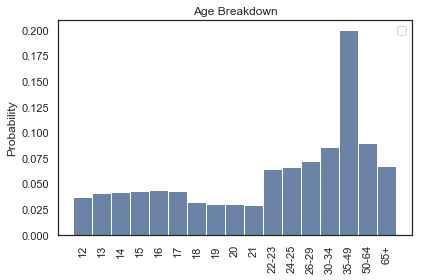

In [4]:
pmf_a = Pmf(df["AGE"])
thinkplot.Hist(pmf_a)
plt.xticks(np.arange(0, 17, step=1), rotation='vertical')
decorate(ylabel='Probability', title = 'Age Breakdown')

In [ ]:
print("Percentage of respondents per age in each group (total % of respondents per range/age range)\n")

print("12-17: ", round(((pmf_a["12"]+pmf_a["13"]+pmf_a["14"]+pmf_a["15"]+pmf_a["16"]+pmf_a["17"])/5)*100, 3), "%")
print("18-21: ", round(((pmf_a["18"]+pmf_a["19"]+pmf_a["20"]+pmf_a["21"])/5)*100, 3), "%")
print("22-23: ", round(((pmf_a["22-23"])/2)*100, 3), "%")
print("24-25: ", round(((pmf_a["24-25"])/2)*100, 3), "%")
print("26-29: ", round(((pmf_a["26-29"])/3)*100, 3), "%")
print("30-34: ", round(((pmf_a["30-34"])/4)*100, 3), "%")
print("35-49: ", round(((pmf_a["35-49"])/14)*100, 3), "%")
print("50-64: ", round(((pmf_a["50-64"])/14)*100, 3), "%")
print("65+ (No division): ", round((pmf_a["65+"]*100), 3), "%")

Percentage of respondents per age in each group (total % of respondents per range/age range)

12-17:  4.877 %
18-21:  2.348 %
22-23:  3.159 %
24-25:  3.269 %
26-29:  2.363 %
30-34:  2.131 %
35-49:  1.423 %
50-64:  0.634 %
65+ (No division):  6.605 %


This visual distribution can be misleading because we have different range sizes of ages for every category, so we need to be extra careful while analysing.
Ages 12 to 21 are treated as seperate categories for each age, while the others are categorized by age ranges. When normalizing for how many people of each age there are in the whole sample, each age between 12-17 makes up an average of 4.9% of the population. This is a relatively large proportion, so we have to consider oversampling for young people.


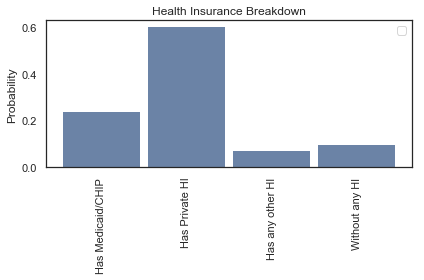

In [ ]:
pmf_a = Pmf(df["HEALTH_INSURANCE"])
thinkplot.Hist(pmf_a)
plt.xticks(np.arange(0, 4, step=1), rotation='vertical')
decorate(ylabel='Probability', title = 'Health Insurance Breakdown')

In [ ]:
print("Percentages")
for a in pmf_a:
    print(a, round(pmf_a[a] * 100, 2) , "%")

Percentages
Has Private HI 59.8 %
Has Medicaid/CHIP 23.61 %
Without any HI 9.4 %
Has any other HI 7.19 %


Most people have Private Health Insurance in this dataset, so this also needs to be taken into consideration. Nearly 60% of the respondents have some type of private health insurance, so we will control for this in our investigation.

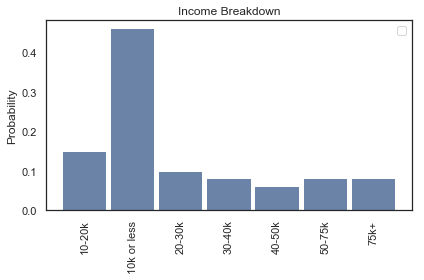

In [ ]:
pmf_a = Pmf(df["INCOME"])
thinkplot.Hist(pmf_a)
plt.xticks(np.arange(0, 7, step=1), rotation='vertical')
decorate(ylabel='Probability', title = 'Income Breakdown')

A large proportion are 12-21 year olds, so that's a likely reason why the 10k or less category has the highest proportion. Family income can paint a more complete picture for those who are too young to make their own salary.

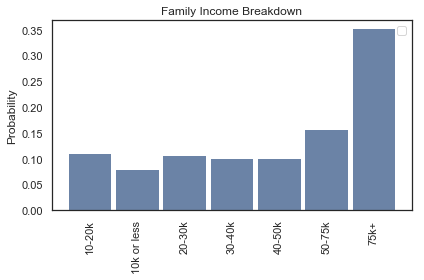

In [ ]:
pmf_a = Pmf(df["FAMILY_INCOME"])
thinkplot.Hist(pmf_a)
plt.xticks(np.arange(0, 7, step=1), rotation='vertical')
decorate(ylabel='Probability', title = 'Family Income Breakdown')

Looking at family income is a better approach because it is not as dependant on the respondent's age. As we can see, the 75k+ category is higher, which is a likely reason why respondents in this dataset are more likely to have a private health insurance.

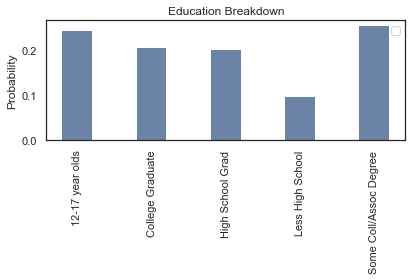

In [ ]:
pmf_a = Pmf(df["EDUCATION"])
thinkplot.Hist(pmf_a, width=width)
plt.xticks(np.arange(0, 5, step=1), rotation='vertical')
decorate(ylabel='Probability', title = 'Education Breakdown')

Most of the respondents over 17 years old have at least finished High School. Only 10% of the respondents have less than High School education, which makes this group slightly underrepresented in the dataset. This is unsuprising given the economic factors.

## Demographic: Comparing two groups
##### Private health insurance vs Others

We will be investigating differences in opioid use between those with private health insurance and those without, so it is important to note if there are other demographic differences to take into account. 

In [ ]:
nopriv_hi = df[df.HEALTH_INSURANCE != "Has Private HI"]
priv_hi = df[df.HEALTH_INSURANCE == "Has Private HI"]
medicaid = df[df.HEALTH_INSURANCE == "Has Medicaid/CHIP"]
no_hi = df[df.HEALTH_INSURANCE == "Without any HI"]

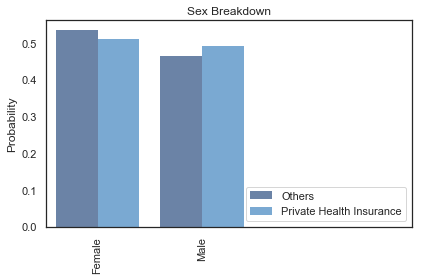

In [ ]:
pmf_a = Pmf(nopriv_hi["SEX"], label='Others')
pmf_b = Pmf(priv_hi["SEX"], label='Private Health Insurance')
thinkplot.Hist(pmf_a, align="right", width=width)
thinkplot.Hist(pmf_b, align="left", width=width)
plt.xticks(np.arange(0, 4, step=1), rotation='vertical')
decorate(ylabel='Probability', title='Sex Breakdown', loc='lower right')

Comparing both groups, we can see that there are small sex differences between the groups. Those who don't have private health insurance are slightly more likely to be female. This change is small enough that we will not investigate it.

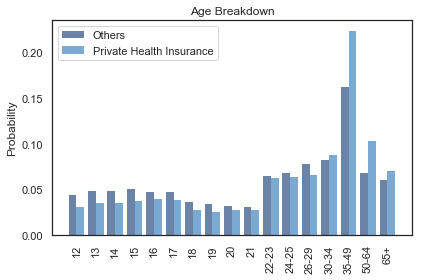

In [ ]:
pmf_a = Pmf(nopriv_hi["AGE"], label='Others')
pmf_b = Pmf(priv_hi["AGE"], label='Private Health Insurance')
thinkplot.Hist(pmf_a, align="right", width=width)
thinkplot.Hist(pmf_b, align="left", width=width)
plt.xticks(np.arange(0, 18, step=1), rotation='vertical')
decorate(ylabel='Probability', title='Age Breakdown', loc='upper left')

Looking at the age PMF for both groups, it is pretty visible that it is more common to have private health insurance in the 35-49 and 50-64 age range. This may be due to age related or cohort related financial factors.

In [ ]:
pmf_a = Pmf(nopriv_hi["FAMILY_INCOME"], label='Others')
pmf_b = Pmf(priv_hi["FAMILY_INCOME"], label='Private Health Insurance')
thinkplot.Hist(pmf_a, align="right", width=width)
thinkplot.Hist(pmf_b, align="left", width=width)
plt.xticks(np.arange(0, 7, step=1), rotation='vertical')
decorate(ylabel='Probability', title='Family Income Breakdown', loc='upper left')

People with private insurance tend to be much wealthier than those without. This is unsuprising due to the cost of insurance.

In [ ]:
pmf_a = Pmf(nopriv_hi["EDUCATION"], label='Others')
pmf_b = Pmf(priv_hi["EDUCATION"], label='Private Health Insurance')
thinkplot.Hist(pmf_a, align="right", width=width)
thinkplot.Hist(pmf_b, align="left", width=width)
plt.xticks(np.arange(0, 10, step=1), rotation='vertical')
decorate(ylabel='Probability', title='Education Breakdown', loc='upper right')

As expected, people who have private health insurance tend to have higher education levels than the other group. This makes sense given the financial demographics.


# Health Insurance and Painkiller use

Now that we have investigated demographic factors, we can dive into the differences in opioid use and abuse. We will start by focusing on use of any kind (prescribed or not) of prescription painkillers. 

Note: the following pain-relievers were defined as prescription pain relievers (excluding "over-the-counter" pain relievers such as aspirin, Tylenol, Advil, or Aleve). A picture of common prescription pain relievers, was presented to the survey taker to help with identification.


In [ ]:
df['USED_VS_NOTUSED_PK'] = ["Used" if value!="Never used" else "Never used" for value in df['PRES_PAINKILLER_USE']]
df['MISUSED_VS_NOTMISUSED_PK'] = ["Misused" if value!="Never misused" else "Never misused" for value in df['REC_PAINKILLER_MISUSE']]

In [ ]:
ct = pd.crosstab(df["HEALTH_INSURANCE"], df["USED_VS_NOTUSED_PK"], 
                 rownames=['Health Insurance'], colnames=['Used Prescription Painkillers'], 
                 margins=True, normalize='index')
(ct*100).round(decimals=3)

As we can see in the tableabove, people who have private health insurance were more likely to have taken opioids. This raises the question of whether increased access is contributing to higher rates of opioid use. 

In [ ]:
ct = pd.crosstab(df["HEALTH_INSURANCE"], df["PRES_PAINKILLER_USE"], 
                 rownames=['Health Insurance'], colnames=['Used Prescription Painkillers'], 
                 margins=True, normalize='index')
(ct*100).round(decimals=3)

In [ ]:
pmf_e = Pmf(nopriv_hi["PRES_PAINKILLER_USE"])
pmf_f = Pmf(priv_hi["PRES_PAINKILLER_USE"])
thinkplot.Hist(pmf_e, align='right', width=width, label = 'Others')
thinkplot.Hist(pmf_f, align='left', width=width, label = 'Private Health Insurance')
plt.xticks(np.arange(0, 3, step=1), rotation='vertical')
thinkplot.Config(ylabel='Probability', title="Recency of use of presctiption painkillers")

print("Others")
for e in pmf_e:
    print(e, round(100 *pmf_e[e], 2), "%")

print("\nPrivate Health Insurance")
for f in pmf_f:
    print(f, round(100 * pmf_f[f], 2) , "%")
    
diff = (pmf_f["Used in 12+ months"] - pmf_e["Used in 12+ months"])*100
print("\nPercentage difference of use in 12+ months in private versus other/no insurance")
print(round(diff, 2), "%")

People who have Medicaid/CHIP were more likely to have taken painkillers within the year than people without insurance, but they were less likely to have used them more than a year ago. Most strikingly, people with private health insurance were 12.39% more likely to have used opioids most recently over a year ago compared to all other populations, indicating that they had discontinued usage at higher rates. This suggests that those on Medicaid/CHIP are using these drugs for longer time periods, or that there has been a recent spike in opioid usage in this demographic. 

In [ ]:
ct = pd.crosstab(df["HEALTH_INSURANCE"], df["MISUSED_VS_NOTMISUSED_PK"],
                 rownames=['Health Insurance'], colnames=['Misused Prescription Painkillers'],
                  margins=True, normalize='index')
(ct*100).round(decimals=3)

In [ ]:
ct = pd.crosstab(df["HEALTH_INSURANCE"], df["REC_PAINKILLER_MISUSE"],
                 rownames=['Health Insurance'], colnames=['Misused Prescription Painkillers'],
                  margins=True, normalize='index')
(ct*100).round(decimals=3)

Misuse of prescription drugs is defined as use in any way not directed by a doctor, including use without a prescription of one's own medication; use in greater amounts, more often, or longer than told to take a drug; or use in any other way not directed by a doctor. 

As we can see from the two tables above, there are a few small differences between the rates of misuse of the groups. In general, people without any health insurance are slightly more likely to have misused opioids in some way. It is also worth noting that those with private health insurance were more likely to have misused in the past, while those on Medicaid/CHIP were more likely to have misused recently.

In [ ]:
ct = pd.crosstab(df["ANY_HI"], df["PRES_PAINKILLER_USE"], 
                 rownames=['Any Health Insurance'], colnames=['Used Prescription Painkillers'],
                 margins=True, normalize="index")
(ct*100).round(decimals=3)

However, by sorting people with and without any health insurance, we can see that having any type of health insurance seems to be related to increased opioid use in the short and long term.

#### Filtering by: History of painkiller use

In order to analyze recency and duration of use, we will filter out anyone who has never used opioids since they will always have null results. With that, we can see a higher relative difference in the variables.

In [ ]:
used_pk = df[df.PRES_PAINKILLER_USE != "Never used"]

In [ ]:
ct = pd.crosstab(used_pk["HEALTH_INSURANCE"], used_pk["PRES_PAINKILLER_USE"],
                 rownames=['Health Insurance'], colnames=['Used Prescription Painkillers'],
                 margins=True, normalize='index')
(ct*100).round(decimals=3)

Of those who had ever used prescription painkillers, those on Medicaid/CHIP had a much higher chance of taking them recently than the other groups. People who have private health insurance were more likely to have taken them in the past.

In [ ]:
ct = pd.crosstab(used_pk["HEALTH_INSURANCE"], used_pk["REC_PAINKILLER_MISUSE"],
                 rownames=['Health Insurance'], colnames=['Misused Prescription Painkillers'],
                  margins=True, normalize='index')
(ct*100).round(decimals=3)

In [ ]:
pmf_a = Pmf(used_pk["REC_PAINKILLER_MISUSE"])
thinkplot.Hist(pmf_a)
plt.xticks(np.arange(0, 4, step=1), rotation='vertical')
decorate(ylabel='Probability', title='Recent painkiller misuse of those who have taken opiods')

By only selecting people who have taken pain relievers at some point, the difference between the groups of health insurance become more apparent. Within this group, people without any health insurance and people with Medicaid/CHIP were more likely to have misused pain relievers. Since the vast majority has never misused, we investigate the same factors later in this notebook filtering by those who have ever misused opioids.

In [ ]:
ct = pd.crosstab(used_pk["ANY_HI"], used_pk["PRES_PAINKILLER_USE"], 
                 rownames=['Any Health Insurance'], colnames=['Used Prescription Painkillers'],
                 margins=True, normalize="index")
(ct*100).round(decimals=3)

In [ ]:
pmf_a = Pmf(used_pk["PRES_PAINKILLER_USE"])
thinkplot.Hist(pmf_a)
plt.xticks(np.arange(0, 3, step=1), rotation='vertical')
decorate(ylabel='Probability', title='Overall Likelihood of Recent Opioid Use for Past Users')

Over half of all people who have ever tried opioids have continued to take them in the past year. Some of this could be because first time use was in the past year, but it is unlikely to be a majority. The more likely cause of this is that these people have continued their use over time.

Of those who had ever used prescription painkillers, those without any health insurance were more likely to have taken them recently (within a year). Yet again, this suggests continued versus past usage, or a recent spike in usage. A spike could be due to policy changes under Medicaid. If usage is continuing, that could be due to differences in treatment types and access to treatment. Those without private health insurance have limitations on frequencies of medical visits, as well as limitations on medical providers accessible. It is possible that since this care is often of lower quality that medication use isn't being treated as carefully by providers, or that alternate solutions are not being pursued.




#### Filtering by: Ever misused painkillers

In order to analyze continued misuse, we're going to filter the respondents for those who have ever misused painkillers. This will allow us to see better the relative difference within this group.

In [ ]:
misused_pk = df[df.REC_PAINKILLER_MISUSE != "Never misused"]

In [ ]:
ct = pd.crosstab(misused_pk["HEALTH_INSURANCE"], misused_pk["REC_PAINKILLER_MISUSE"],
                 rownames=['Health Insurance'], colnames=['Misused Prescription Painkillers'],
                  margins=True, normalize='index')
(ct*100).round(decimals=3)

In [ ]:
pmf_a = Pmf(misused_pk["REC_PAINKILLER_MISUSE"])
thinkplot.Hist(pmf_a)
plt.xticks(np.arange(0, 4, step=1), rotation='vertical')
decorate(ylabel='Probability', title='Recent painkiller misuse of those who have taken opiods')

This difference in probabilities of abuse between insurance types suggests that there is a factor related to health insurance that is causing abuse. We don't have enough data to say that the health insurance itself is the cause, but health insurance type is closely tied with socioeconomic factors, rates of disability, and military affiliation. This increase of continued use and abuse in those without private health insurance could also be due to the limit to access of care.